In [104]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [105]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
embeddings_subpath = "ukb_random_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/summary/SexSmallBrain_ukb_without_residualization.csv"
label = "Sex"
max_iter = 2000
cv = 3

In [106]:
participants = pd.read_csv(participants_file, index_col=0)
q_80 = participants["BrainVolumeFreeSurfer_mm3"].quantile(0.8)


In [107]:
participants = participants[participants["BrainVolumeFreeSurfer_mm3"]>=q_80]

In [108]:
participants = participants[["Sex", "BrainVolumeFreeSurfer_mm3"]]

In [109]:
def closest_point(point, points):
    """ Find closest point from a list of points. """
    return np.argsort((points-point)**2)[:10]

In [110]:
participants

,Sex,BrainVolumeFreeSurfer_mm3
participant_id,,
sub-4334619,1,1410387.0
sub-5767106,1,1385492.0
sub-3405143,1,1383324.0
sub-1502040,1,1346017.0
sub-5458483,0,1304562.0
...,...,...
sub-1981949,1,1351739.0
sub-1936273,1,1371857.0
sub-3101225,1,1335619.0


In [111]:
females = participants[participants.Sex==0].copy()
males = participants[participants.Sex==1].copy()

males["chosen"] = 0
for one_female in females.iloc[:,1]:
    chosen_rows = closest_point(one_female, males.iloc[:,1])
    for chosen_row in chosen_rows:
        if males.iloc[chosen_row, 2] == 0:
            males.iloc[chosen_row, 2] = 1
            break

participants = pd.concat([females, males[males.chosen==1][["Sex", "BrainVolumeFreeSurfer_mm3"]]])

In [112]:
# participants[participants.Sex==0]["BrainVolumeFreeSurfer_mm3"].hist(bins=100)

In [113]:
# participants[participants.Sex==1]["BrainVolumeFreeSurfer_mm3"].hist(bins=100)

In [114]:
participants = participants[[label]].dropna()

array([[<Axes: title={'center': 'Sex'}>]], dtype=object)

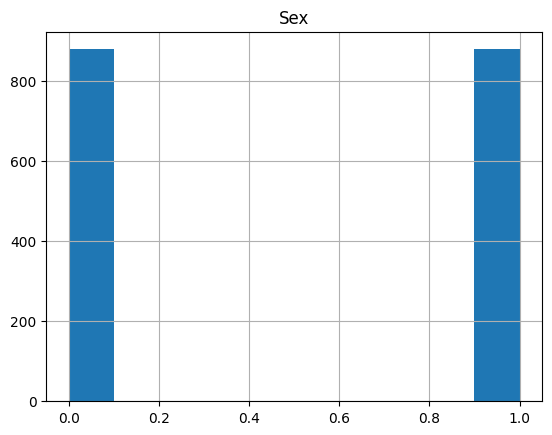

In [115]:
participants.hist()

In [116]:
participants

,Sex
participant_id,
sub-5458483,0
sub-2011528,0
sub-4205268,0
sub-2843269,0
sub-3231417,0
...,...
sub-2641491,1
sub-5182900,1
sub-1569024,1


In [117]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [118]:
model_paths = get_model_paths(path_champollion)

In [119]:
model_paths[:5]

['/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1']

In [120]:
def compute(model_path):
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label]].merge(embeddings, left_index=True, right_index=True)
    
    # Classifies
    X = merged.drop([label], axis=1)
    Y = merged[[label]].astype(float)
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)
    df2 = X.copy()

    # Makes OLS
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y[label], df2)
    results = model.fit()
    f_value = results.fvalue
    p_value = results.f_pvalue
    
    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(f_value)
    
    # Returns result
    return (region, f_value, p_value, model_name, region_path, model_path)

In [121]:
result = []
for model_path in model_paths:
    result.append(compute(model_path))

Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2
1.2414094754678913
Treating S.C.-sylv._left: SC-sylv_left/14-00-57_116 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116
1.093207226383815
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/09-33-02_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0
1.36713409021025
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/20-15-00_117 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117
1.1580781701079348
Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
1.5090207243033167
Treating S.C.-sylv._right: SC-sylv_right/11-43-38_3 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_right/11-43-38_3

In [122]:
result

[('S.C.-sylv._left',
  1.2414094754678913,
  0.03348236004905626,
  '11-43-38_2',
  'SC-sylv_left/11-43-38_2',
  '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2'),
 ('S.C.-sylv._left',
  1.093207226383815,
  0.2247207742422139,
  '14-00-57_116',
  'SC-sylv_left/14-00-57_116',
  '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116'),
 ('S.F.inter.-S.F.sup._left',
  1.36713409021025,
  0.004035228582839341,
  '09-33-02_0',
  'SFinter-SFsup_left/09-33-02_0',
  '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0'),
 ('S.T.i.-S.T.s.-S.T.pol._right',
  1.1580781701079348,
  0.10679846952971023,
  '20-15-00_117',
  'STi-STs-STpol_right/20-15-00_117',
  '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117'),
 ('F.Coll.-S.Rh._right',
  1.5090207243033167,
  0.00024568728219460966,
  '09-45-57_1',
  'FColl-SRh_right/09-45-57_1',
  

In [123]:
df = pd.DataFrame(result, columns=['region', 'f_value', 'p_value', 'model_name', 'region_path', 'model_path'])

In [124]:
df

,region,f_value,p_value,model_name,region_path,model_path
0,S.C.-sylv._left,1.241409,0.033482,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...
1,S.C.-sylv._left,1.093207,0.224721,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...
2,S.F.inter.-S.F.sup._left,1.367134,0.004035,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...
3,S.T.i.-S.T.s.-S.T.pol._right,1.158078,0.106798,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...
4,F.Coll.-S.Rh._right,1.509021,0.000246,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...
...,...,...,...,...,...,...
72,S.F.inter.-S.F.sup._right,1.398800,0.002234,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...
73,S.T.s._left,1.522901,0.000183,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...
74,F.C.M.post.-S.p.C._right,1.752887,0.000001,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...
75,ORBITAL_right,1.478441,0.000463,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...


In [125]:
df['side'] = df['region'].str.split('_').str[-1]

In [126]:
def plot_horizontal(res, region_name, ax, f_value, p_value, f2_value, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=f_value, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=-np.log10(0.05/76), color='black', linestyle='-')
    ax.barh(res[region_name], -np.log10(res[f2_value]), fill=True, color='lightgray')
    ax.errorbar(res[f_value], res[region_name], xerr=0, fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    # ax.set_xlim((0.3, 1.0))
    ax.set_title(title)


In [127]:
df.sort_values(by="f_value", ascending=False)

,region,f_value,p_value,model_name,region_path,model_path,side
33,F.P.O.-S.Cu.-Sc.Cal._left,2.153603,4.552964e-11,20-03-37_0,FPO-SCu-ScCal_left/20-03-37_0,/neurospin/dico/data/deep_folding/current/mode...,left
17,S.T.i.-S.T.s.-S.T.pol._left,1.928669,1.377182e-08,14-30-34_34,STi-STs-STpol_left/14-30-34_34,/neurospin/dico/data/deep_folding/current/mode...,left
16,F.Coll.-S.Rh._left,1.915894,1.893495e-08,09-45-57_0,FColl-SRh_left/09-45-57_0,/neurospin/dico/data/deep_folding/current/mode...,left
66,ORBITAL_left,1.783965,4.796387e-07,20-56-02_0,ORBITAL_left/20-56-02_0,/neurospin/dico/data/deep_folding/current/mode...,left
8,S.F.int.-S.R._left,1.775427,5.888260e-07,09-00-43_0,SFint-SR_left/09-00-43_0,/neurospin/dico/data/deep_folding/current/mode...,left
...,...,...,...,...,...,...,...
36,S.T.s._right,1.097959,2.138910e-01,11-43-38_1,STs_right/11-43-38_1,/neurospin/dico/data/deep_folding/current/mode...,right
1,S.C.-sylv._left,1.093207,2.247208e-01,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...,left
26,CINGULATE_left,1.078076,2.615404e-01,16-58-04_0,2024-07-16/16-58-04_0,/neurospin/dico/data/deep_folding/current/mode...,left
28,CINGULATE_right,1.070017,2.825651e-01,09-52-22_75,CINGULATE_right/09-52-22_75,/neurospin/dico/data/deep_folding/current/mode...,right


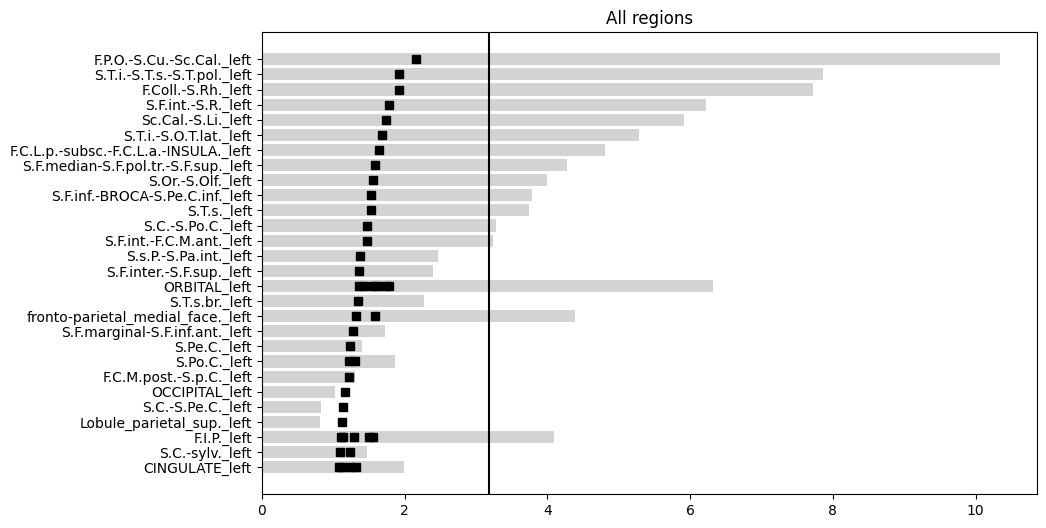

In [128]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "f_value", "f_value", "p_value",  True, "All regions")
plt.show()

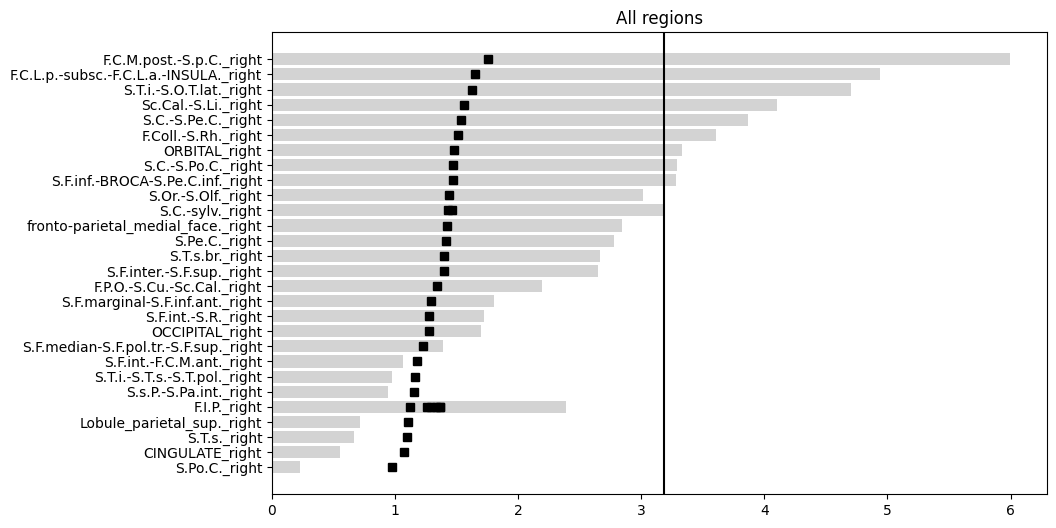

In [129]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "f_value", "p_value", "p_value",  True, "All regions")
plt.show()

In [130]:
df

,region,f_value,p_value,model_name,region_path,model_path,side
0,S.C.-sylv._left,1.241409,0.033482,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...,left
1,S.C.-sylv._left,1.093207,0.224721,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...,left
2,S.F.inter.-S.F.sup._left,1.367134,0.004035,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...,left
3,S.T.i.-S.T.s.-S.T.pol._right,1.158078,0.106798,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...,right
4,F.Coll.-S.Rh._right,1.509021,0.000246,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...,right
...,...,...,...,...,...,...,...
72,S.F.inter.-S.F.sup._right,1.398800,0.002234,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...,right
73,S.T.s._left,1.522901,0.000183,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...,left
74,F.C.M.post.-S.p.C._right,1.752887,0.000001,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...,right
75,ORBITAL_right,1.478441,0.000463,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...,right


In [131]:
# df.to_csv(output_filename)